In [2]:
import numpy as np
import torchvision
import torch
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# !git clone https://github.com/karpathy/minGPT.git
# %cd minGPT/

In [4]:
# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [5]:
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [6]:
from mingpt.utils import set_seed
set_seed(42)

In [7]:
from torch.utils.data import DataLoader, Subset

In [8]:
root = './'
train_data = torchvision.datasets.MNIST(root, train=True, transform=None, target_transform=None, download=True)
test_data  = torchvision.datasets.MNIST(root, train=False, transform=None, target_transform=None, download=True)
print(len(train_data), len(test_data))

100%|██████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:07<00:00, 1370206.50it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 1233573.60it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:01<00:00, 1369252.16it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 5673177.12it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

60000 10000


In [9]:
indices = [i for i, (img, label) in enumerate(train_data) if label == 5]
train_dataset = Subset(train_data, indices)

test_dataset = Subset(test_data, [i for i, (img, label) in enumerate(test_data) if label == 5])

In [10]:
train_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x702c967c7850>,
 <torch.utils.data.dataset.Subset at 0x702c966d50d0>)

In [11]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train

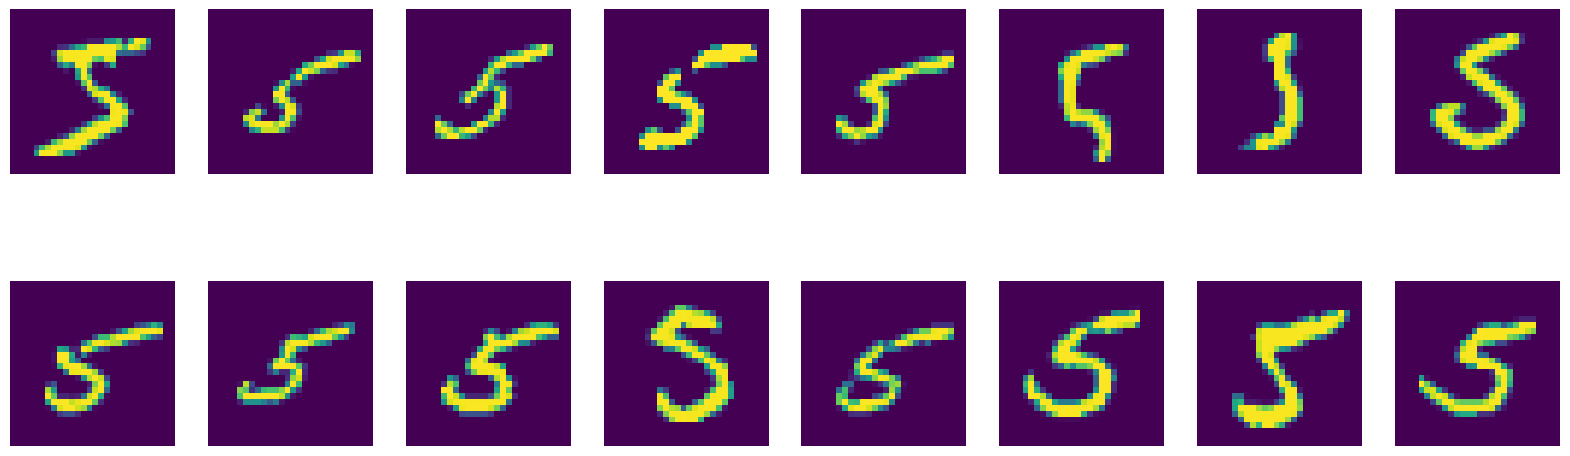

In [12]:
n_samples = 16
ncol = 8
nrow = n_samples // ncol + 1
plt.figure(figsize=(20, 10))
for i in range(n_samples):
    
    # encode and decode random data
    x, y = train_dataset.__getitem__(i)
    xpt = torch.from_numpy(np.array(x)).float().view(28*28)
  
    
    # these images should look normal ideally
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(xpt.view(28,28).numpy().astype(np.uint8))
    plt.axis('off')
    

In [13]:
from torch.utils.data import Dataset
class ImageDataset(Dataset):
    """
    wrap up the pytorch CIFAR-10 dataset into our own, which will convert images into sequences of integers
    """
    
    def __init__(self, pt_dataset):
        self.pt_dataset = pt_dataset
        
        
        self.vocab_size = 256
        self.block_size = 28*28 - 1
        
    def __len__(self):
        return len(self.pt_dataset)

    def __getitem__(self, idx):
        x, y = self.pt_dataset[idx]
        x = torch.from_numpy(np.array(x)).view(-1) # flatten out all pixels
        x = x.long() # reshuffle pixels with any fixed permutation and -> float
        
        return x[:-1],x[1:] # always just predict the next one in the sequence

train_dataset = ImageDataset(train_dataset)
test_dataset = ImageDataset(test_dataset)
train_dataset[10][0].size() # one example image flattened out into integers

torch.Size([783])

In [14]:
!pwd

/home/mad/code/olimpai/mnistgpt


In [15]:
from mingpt.model import GPT, GPTConfig, GPT1Config

# we'll do something a bit smaller
mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                  embd_pdrop=0.0, resid_pdrop=0.0, attn_pdrop=0.0,
                  n_layer=6, n_head=8, n_embd=256)
model = GPT(mconf)

04/05/2024 00:38:34 - INFO - mingpt.model -   number of parameters: 5.070592e+06


In [31]:
from mingpt.trainer import Trainer, TrainerConfig

tokens_per_epoch = len(train_data) * train_dataset.block_size
train_epochs = 4 # todo run a bigger model and longer, this is tiny

# initialize a trainer instance and kick off training
tconf = TrainerConfig(max_epochs=train_epochs, batch_size=8, learning_rate=3e-3,
                      betas = (0.9, 0.95), weight_decay=0,
                      lr_decay=True, warmup_tokens=tokens_per_epoch, final_tokens=train_epochs*tokens_per_epoch,
                      ckpt_path='mnist.pt',
                      num_workers=8)
trainer = Trainer(model, train_dataset, test_dataset, tconf)
trainer.train()

epoch 1 iter 677: train loss 0.96642. lr 2.710500e-04: 100%|██████████| 678/678 [01:20<00:00,  8.39it/s]
04/05/2024 00:21:54 - INFO - mingpt.trainer -   test loss: 0.907077
04/05/2024 00:21:54 - INFO - mingpt.trainer -   saving mnist.pt
epoch 2 iter 677: train loss 0.93734. lr 5.421000e-04: 100%|██████████| 678/678 [01:21<00:00,  8.29it/s]
04/05/2024 00:23:21 - INFO - mingpt.trainer -   test loss: 0.826282
04/05/2024 00:23:21 - INFO - mingpt.trainer -   saving mnist.pt
epoch 3 iter 677: train loss 0.76973. lr 8.131500e-04: 100%|██████████| 678/678 [01:21<00:00,  8.27it/s]
04/05/2024 00:24:48 - INFO - mingpt.trainer -   test loss: 0.759585
04/05/2024 00:24:48 - INFO - mingpt.trainer -   saving mnist.pt
epoch 4 iter 677: train loss 0.76064. lr 1.084200e-03: 100%|██████████| 678/678 [01:22<00:00,  8.26it/s]
04/05/2024 00:26:15 - INFO - mingpt.trainer -   test loss: 0.730920
04/05/2024 00:26:15 - INFO - mingpt.trainer -   saving mnist.pt


In [32]:
checkpoint = torch.load('mnist.pt')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [33]:
counts = torch.ones(256) # start counts as 1 not zero, this is called "smoothing"

nest = 5000 # how many images to use for the estimation
for i in range(nest):
    a, _ = train_dataset[i]
    t = a[0].item() # index of first token in the sequence
    counts[t] += 1
prob = counts/counts.sum()

In [34]:
from mingpt.utils import sample

n_samples = 32
start_pixel = np.random.choice(np.arange(256), size=(n_samples, 1), replace=True, p=prob)
start_pixel = torch.from_numpy(start_pixel).to(trainer.device)
pixels = sample(model, start_pixel, 28*28-1, temperature=1.0, sample=True, top_k=100)

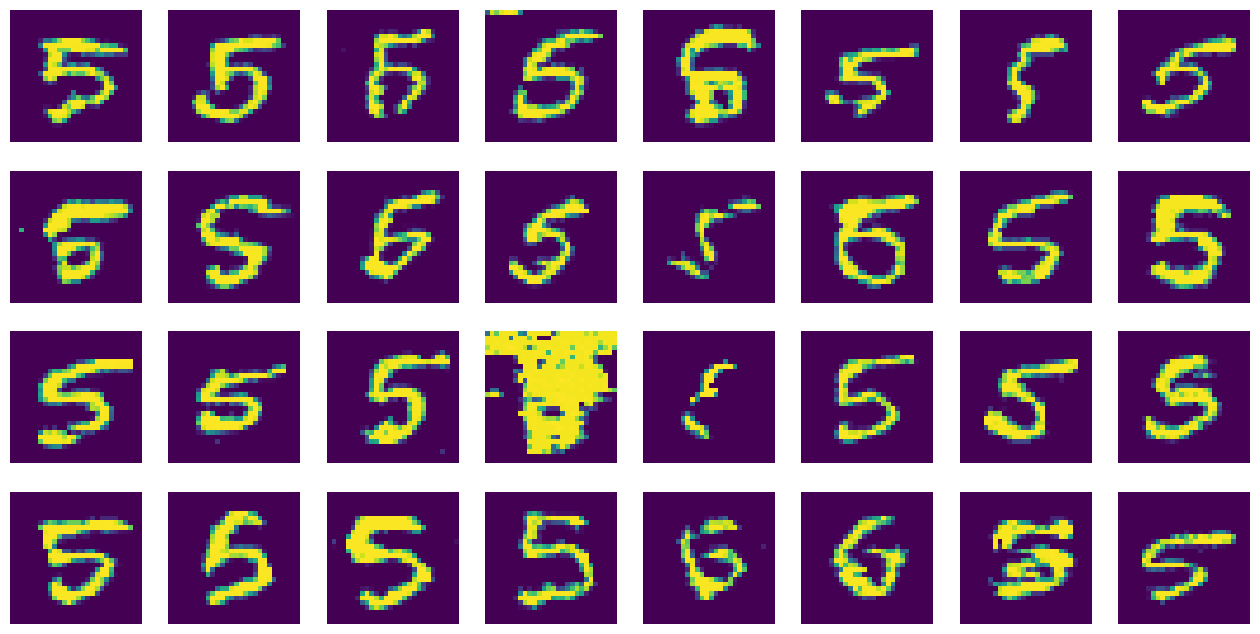

In [35]:


ncol = 8
nrow = n_samples // ncol
plt.figure(figsize=(16, 8))
for i in range(n_samples):
    pxi = pixels[i] # note: undo the encoding permutation
    
    plt.subplot(nrow, ncol, i+1)
    plt.imshow(pxi.view(28,28).cpu().numpy().astype(np.uint8))
    plt.axis('off')